In [2]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///..//Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
#  use inspector to get column names/types for measurement table
inspector = inspect(engine)

mcolumns = inspector.get_columns('measurement')
for c in mcolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# use inspector to get column names/types for station table
scolumns = inspector.get_columns('station')
for c in scolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# get the max date in dataset 
MaxDate = engine.execute('SELECT max(date) FROM measurement order by date desc limit 1').fetchall()
for maxdate in MaxDate:
    print (f'MaxDate: {maxdate}')

# lastest date
maxDBDT = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print (f'maxDBDT: {maxDBDT}')

MaxDate: ('2017-08-23',)
maxDBDT: ('2017-08-23',)


Today: 2018-09-05
lastDBDT: 2017-08-23 00:00:00
A year ago: 2016-08-23 00:00:00


<IPython.core.display.Javascript object>


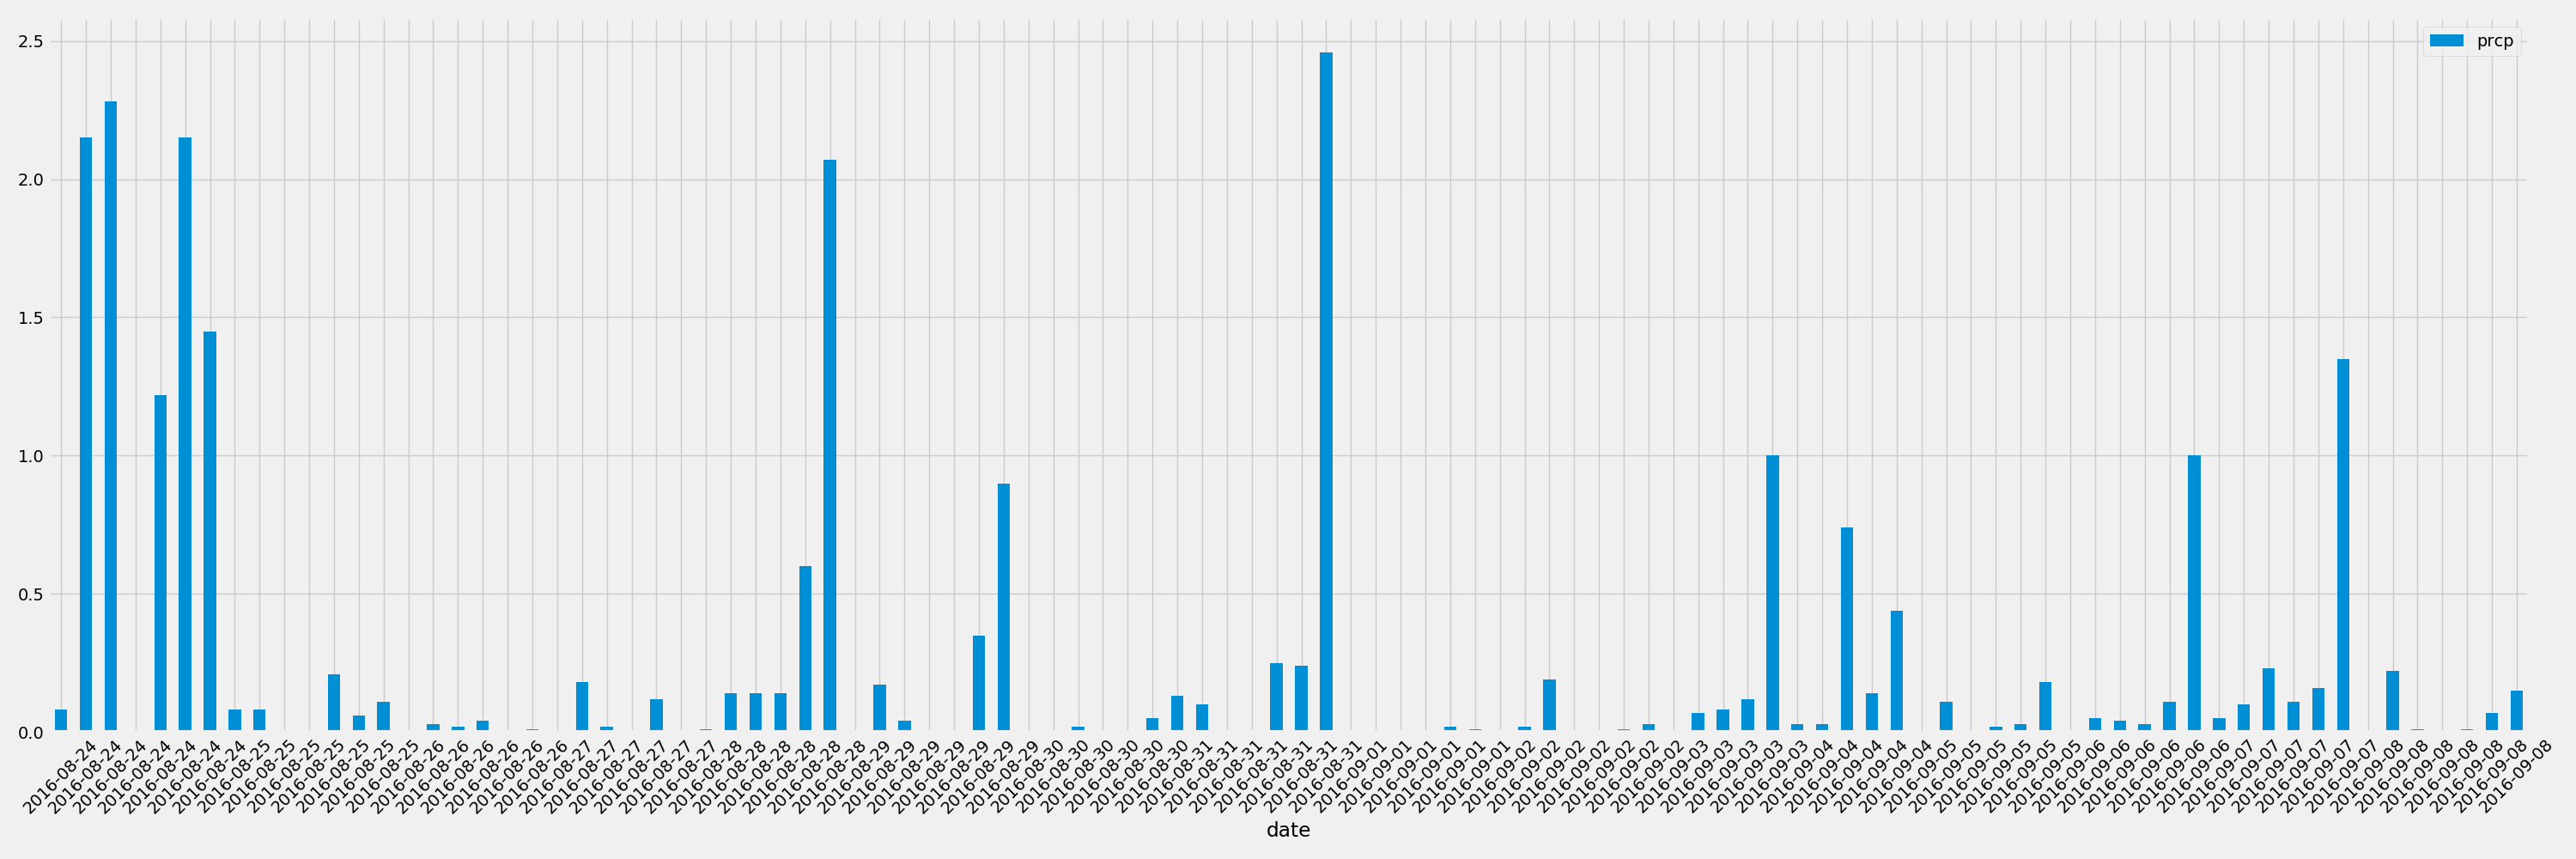

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
todayDT = dt.date.today()
print(f'Today: {todayDT}')

####   DIRECTION YIELDS NO RESULT.  MAX(date) in database is 2017-08-23, see section above
####   Change to use MAX(date) - 1 year

lastDBDT = dt.datetime(2017, 8,23)
print (f'lastDBDT: {lastDBDT}')

#yearAgoDT = dt.datetime(todayDT - dt.timedelta(days=365))
yearAgoDT = lastDBDT- dt.timedelta(days=365)
print (f'A year ago: {yearAgoDT}')


# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp ]

#lastYearPrec = session.query(*sel).filter(Measurement.date >= yearAgoDT).\
#               filter(Measurement.date <= lastDBDT).order_by(Measurement.date).all()

lastYearPrec = session.query(*sel).filter(Measurement.date >= yearAgoDT).\
               filter(Measurement.date <= lastDBDT).order_by(Measurement.date).limit(100).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(lastYearPrec, columns=['date', 'prcp'])
df.head()

# Sort the dataframe by date
df.set_index('date', inplace=True)
df.sort_values('date')


# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar(figsize=(30, 10), rot=45)
plt.tight_layout()
plt.show()

# Rotate the xticks for the dates


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,88.000000
mean,0.284773
std,0.565139
min,0.000000
25%,0.010000
50%,0.070000
75%,0.180000
max,2.460000


In [18]:
# How many stations are available in this dataset?
stations =  session.query(Measurement).group_by(Measurement.station).count()
print (stations)

9


In [19]:
# What are the most active stations?
# List the stations and the counts in descending order.
#stationCounts =  session.query(Measurement).group_by(Measurement.station).all()
stationCounts = engine.execute('SELECT station, count(*) AS station_cnt FROM measurement group by station order by count(*) desc').fetchall()

print (stationCounts)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

activesel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

activeStationStat = session.query(*activesel).filter(Measurement.station == "USC00519281").all()
activeStationStat

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tempsel = [Measurement.date, Measurement.tobs ]

lastYearPrec = session.query(*tempsel).filter(Measurement.date >= yearAgoDT).\
               filter(Measurement.station == "USC00519281").\
               filter(Measurement.date <= lastDBDT).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
#df = pd.DataFrame(may_averages, columns=['stock', 'open_avg', 'high_avg', 'low_avg', 'close_avg'])
activeTobs_df = pd.DataFrame(lastYearPrec, columns=['date', 'tobs'])
activeTobs_df.head()


,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


<IPython.core.display.Javascript object>


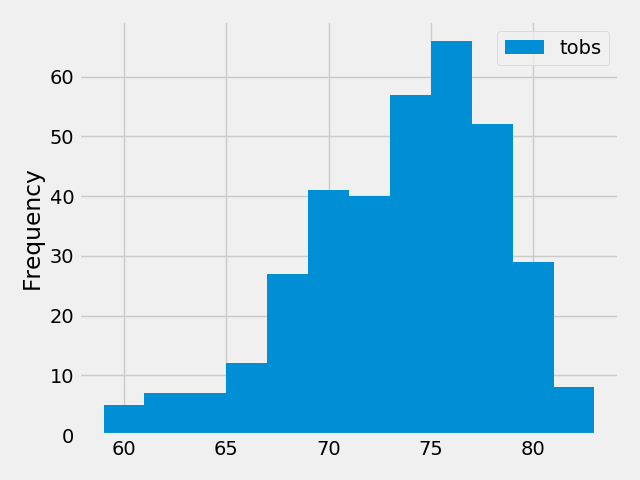

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

activeTobs_df.plot.hist(bins=12)
plt.tight_layout()
plt.show()

In [110]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    tobstats = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
      
    return tobstats

print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [111]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = '2017-06-25'
end_date = '2017-07-05'

tripAvgTemp = calc_temps(start_date, end_date)
print (tripAvgTemp)
type(tripAvgTemp)


[(71.0, 77.9076923076923, 87.0)]


list

In [112]:
#activeTobs_df = pd.DataFrame(lastYearPrec, columns=['date', 'tobs'])

#tripAvgTemp_df = pd.DataFrame(np.array(tripAvgTemp).reshape(1,3), columns = list("abc"))
tripTemp_df = pd.DataFrame(np.array(tripAvgTemp).reshape(1,3), columns = ["min", "avg", "max"])
tripTemp_df

tripAvgTemp_df = tripTemp_df.iloc[:,1]
tripAvgTemp_df

ptp = tripTemp_df.iloc[0,2] - tripTemp_df.iloc[0,0]
print (ptp)

16.0


In [118]:
#tripTemp_df.plot(kind='bar')
#plt.show()

tripAvgTemp_df.plot(kind="bar", yerr = ptp, title = "Trip Avg Temp", figsize=(5, 8))
plt.ylabel("Temp(F)")
plt.tight_layout()
plt.show()


In [56]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainSel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           func.sum(Measurement.prcp)]


prcptats = session.query(*rainSel).\
                         filter(Measurement.station == Station.station).\
                         filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                         group_by(Station.station).\
                         order_by(func.sum(Measurement.prcp).desc()).all()
             
prcptats    


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.88),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.5599999999999999),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.45000000000000007),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.2),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.12),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.09000000000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


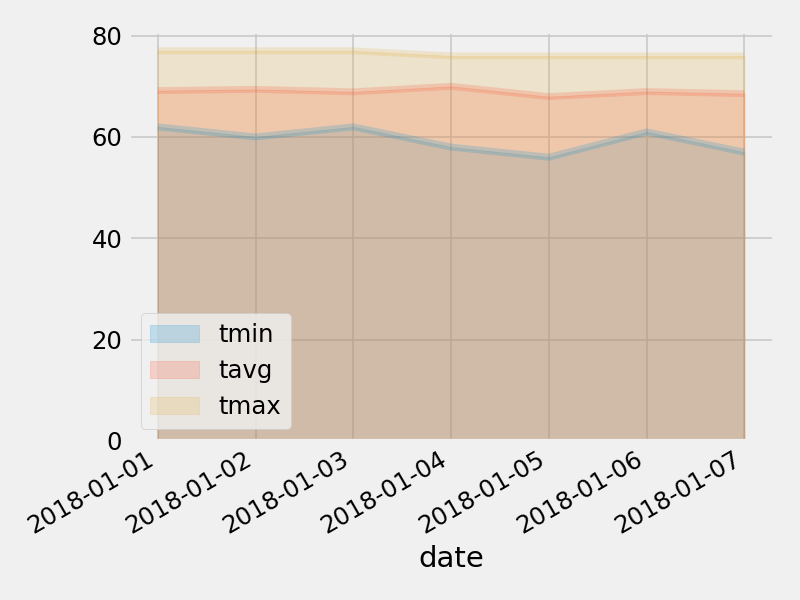

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
